In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [ ]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:03<00:00, 59.01it/s] 


In [ ]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [ ]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseV16(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8453

60/60 [==============================] - 56s 630ms/step - loss: 0.3409 - accuracy: 0.8453 - val_loss: 0.1839 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9505

60/60 [==============================] - 38s 630ms/step - loss: 0.1327 - accuracy: 0.9505 - val_loss: 0.0314 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9589

60/60 [==============================] - 37s 607ms/step - loss: 0.1018 - accuracy: 0.9589 - val_loss: 0.0186 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/30
60/60 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9609

60/60 [==============================] - 38s 633ms/step - loss: 0.0988 - accuracy: 0.9609 - val_loss: 0.0134 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/30
60/60 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9635

60/60 [==============================] - 36s 600ms/step - loss: 0.0797 - accuracy: 0.9635 - val_loss: 0.0284 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 6/30
60/60 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9672

60/60 [==============================] - 37s 608ms/step - loss: 0.0761 - accuracy: 0.9672 - val_loss: 0.0181 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 7/30
60/60 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9708

60/60 [==============================] - 37s 619ms/step - loss: 0.0704 - accuracy: 0.9708 - val_loss: 0.0116 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 8/30
60/60 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9755

60/60 [==============================] - 39s 637ms/step - loss: 0.0616 - accuracy: 0.9755 - val_loss: 0.0169 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 9/30
60/60 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9688

60/60 [==============================] - 36s 600ms/step - loss: 0.0661 - accuracy: 0.9688 - val_loss: 0.0095 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 10/30
60/60 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9776

60/60 [==============================] - 36s 602ms/step - loss: 0.0584 - accuracy: 0.9776 - val_loss: 0.0074 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 11/30
60/60 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9661

60/60 [==============================] - 37s 604ms/step - loss: 0.0712 - accuracy: 0.9661 - val_loss: 0.0045 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 12/30
60/60 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9734

60/60 [==============================] - 38s 638ms/step - loss: 0.0623 - accuracy: 0.9734 - val_loss: 0.0136 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 13/30
60/60 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9792

60/60 [==============================] - 36s 603ms/step - loss: 0.0565 - accuracy: 0.9792 - val_loss: 0.0115 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 14/30
60/60 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9672

60/60 [==============================] - 37s 606ms/step - loss: 0.0661 - accuracy: 0.9672 - val_loss: 0.0141 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 15/30
60/60 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9771

60/60 [==============================] - 36s 600ms/step - loss: 0.0567 - accuracy: 0.9771 - val_loss: 0.0067 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/30
60/60 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9807

60/60 [==============================] - 38s 626ms/step - loss: 0.0480 - accuracy: 0.9807 - val_loss: 0.0095 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 17/30
60/60 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9786

60/60 [==============================] - 37s 607ms/step - loss: 0.0517 - accuracy: 0.9786 - val_loss: 0.0168 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 18/30
60/60 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9750

60/60 [==============================] - 37s 608ms/step - loss: 0.0543 - accuracy: 0.9750 - val_loss: 0.0074 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 19/30
60/60 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9745

60/60 [==============================] - 37s 622ms/step - loss: 0.0519 - accuracy: 0.9745 - val_loss: 0.0120 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 20/30
60/60 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9766

60/60 [==============================] - 38s 638ms/step - loss: 0.0491 - accuracy: 0.9766 - val_loss: 0.0051 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 21/30
60/60 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9823

60/60 [==============================] - 36s 600ms/step - loss: 0.0411 - accuracy: 0.9823 - val_loss: 0.0101 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 22/30
60/60 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9849

60/60 [==============================] - 38s 626ms/step - loss: 0.0354 - accuracy: 0.9849 - val_loss: 0.0064 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 23/30
60/60 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9786

60/60 [==============================] - 36s 604ms/step - loss: 0.0413 - accuracy: 0.9786 - val_loss: 0.0037 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/30
60/60 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9865

60/60 [==============================] - 39s 647ms/step - loss: 0.0319 - accuracy: 0.9865 - val_loss: 0.0055 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/30
60/60 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9812

60/60 [==============================] - 36s 605ms/step - loss: 0.0428 - accuracy: 0.9812 - val_loss: 0.0039 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 26/30
60/60 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9740

60/60 [==============================] - 37s 620ms/step - loss: 0.0499 - accuracy: 0.9740 - val_loss: 0.0065 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/30
60/60 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9781

60/60 [==============================] - 37s 617ms/step - loss: 0.0405 - accuracy: 0.9781 - val_loss: 0.0057 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 28/30
60/60 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9797

60/60 [==============================] - 38s 640ms/step - loss: 0.0485 - accuracy: 0.9797 - val_loss: 0.0066 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 29/30
60/60 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9812

60/60 [==============================] - 37s 620ms/step - loss: 0.0405 - accuracy: 0.9812 - val_loss: 0.0066 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 30/30
60/60 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9823

60/60 [==============================] - 36s 604ms/step - loss: 0.0367 - accuracy: 0.9823 - val_loss: 0.0435 - val_accuracy: 0.9812 - lr: 1.0000e-04


20/20 [==============================] - 4s 142ms/step
Confusion matrix, without normalization
[[206   0   0]
 [  1 199   0]
 [ 23   0 182]]


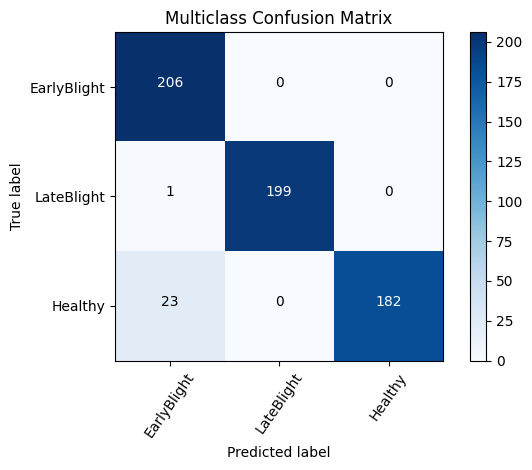

In [ ]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

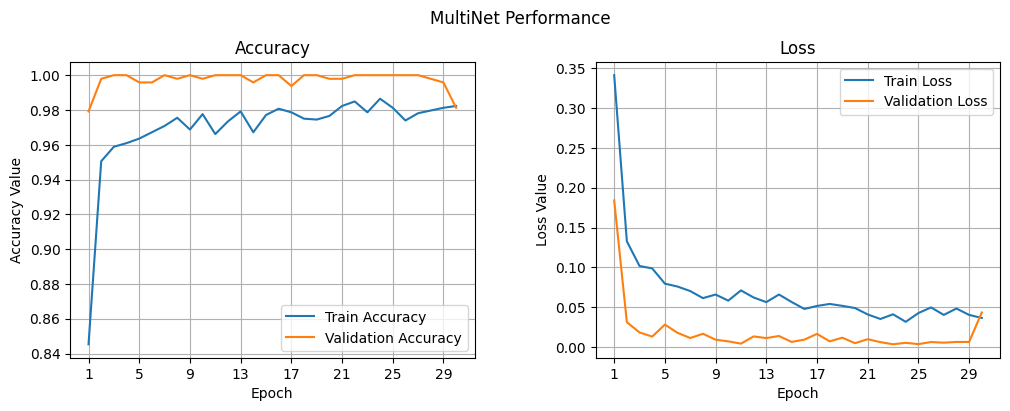

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 31, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 31, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 2s 98ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       0.90      1.00      0.94       206
  LateBlight       1.00      0.99      1.00       200
     Healthy       1.00      0.89      0.94       205

    accuracy                           0.96       611
   macro avg       0.97      0.96      0.96       611
weighted avg       0.96      0.96      0.96       611



In [ ]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("ResNet50")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 2s 99ms/step
ResNet50
Accuracy: 0.9607201309328969
F1 Score: 0.9607596811888973
precision: 0.9649516985349886
recall: 0.9607201309328969
MSE: 0.15220949263502456
MAE: 0.07692307692307693


In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

20/20 [==============================] - 2s 98ms/step


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.9164063438663943

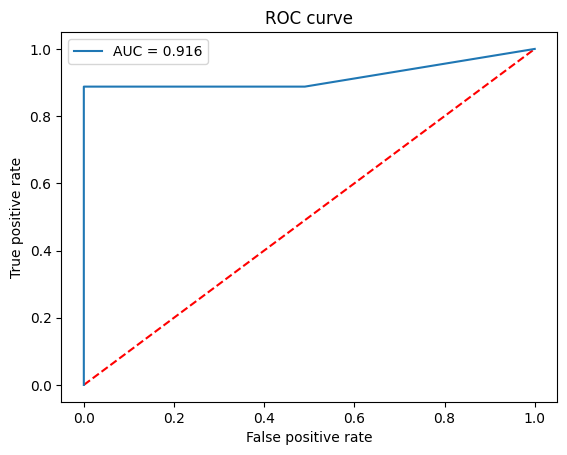

In [ ]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
